# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [28]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random

In [2]:
# Load pickled data
import pickle

# Fill this in based on where you saved the training and testing data
training_file = "data/train.p"
testing_file = "data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [3]:
### To start off let's do a basic data summary.

# Number of training examples
n_train = len(y_train)

# Number of testing examples
n_test = len(y_test)

# What's the shape of an image?
image_shape = X_train[0].shape

# How many classes are in the dataset
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


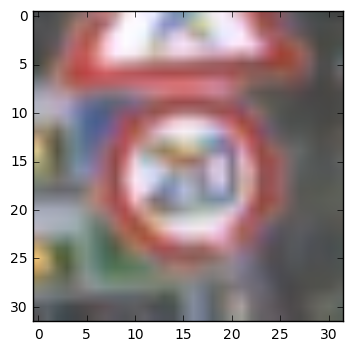

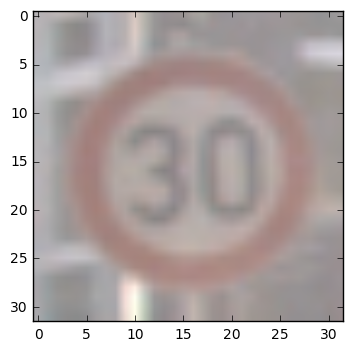

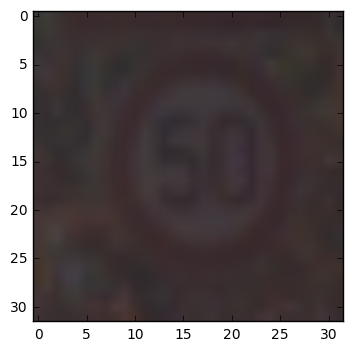

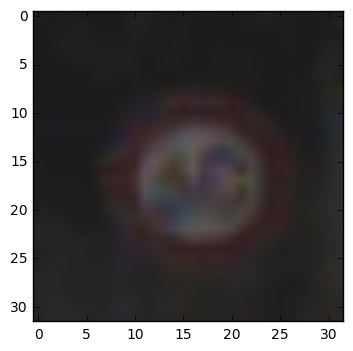

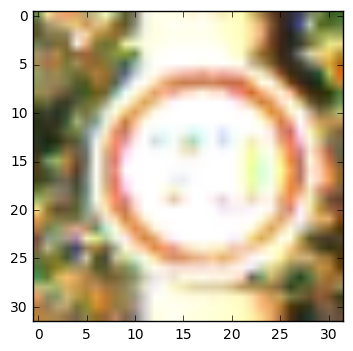

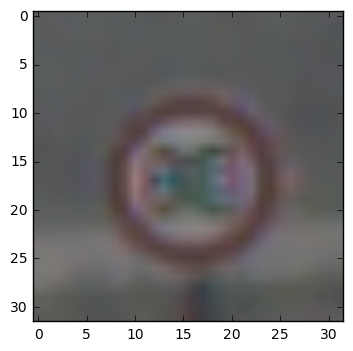

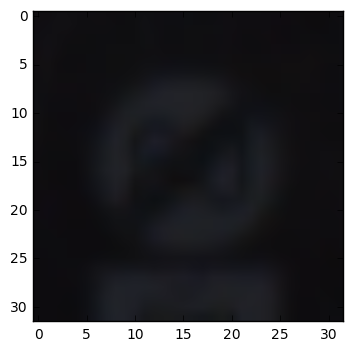

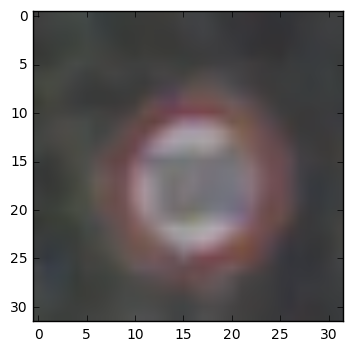

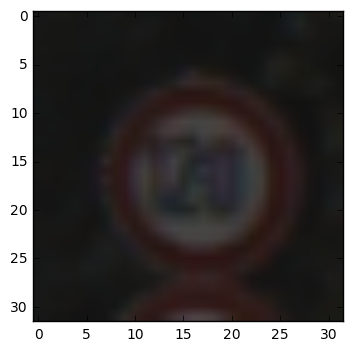

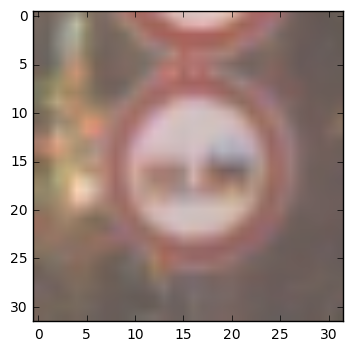

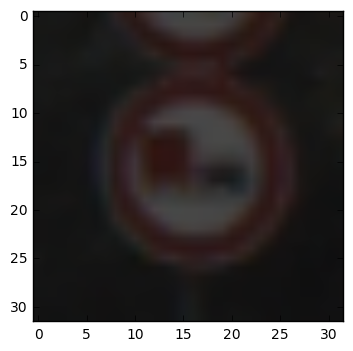

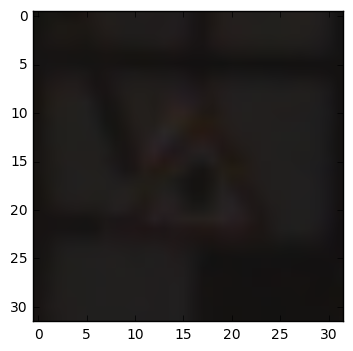

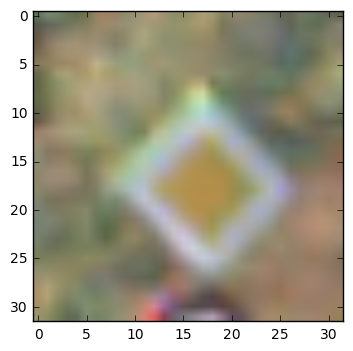

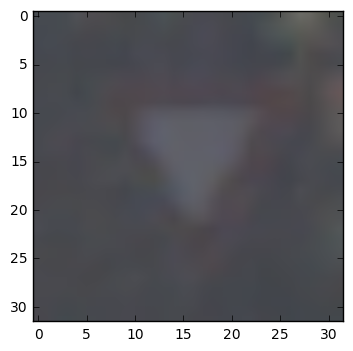

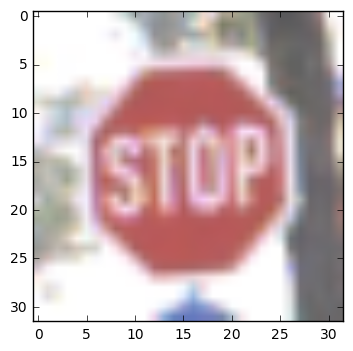

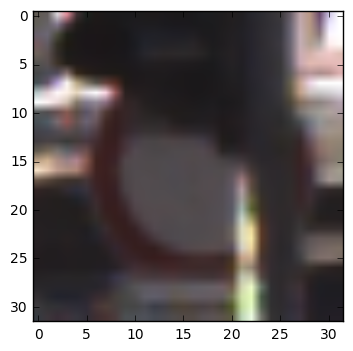

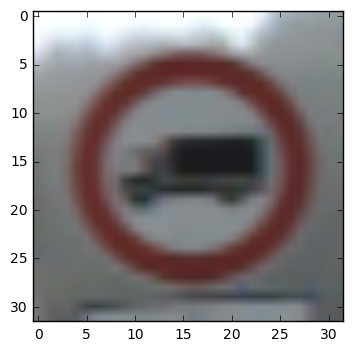

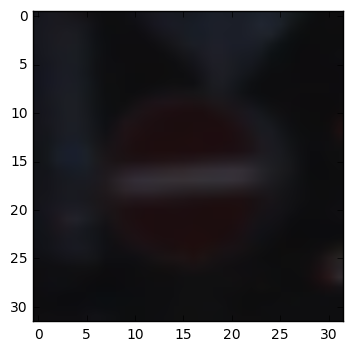

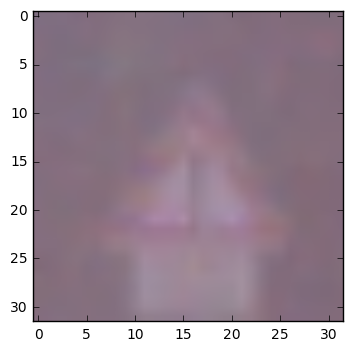

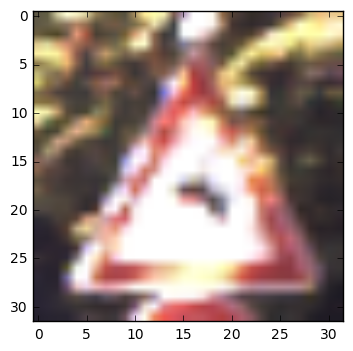

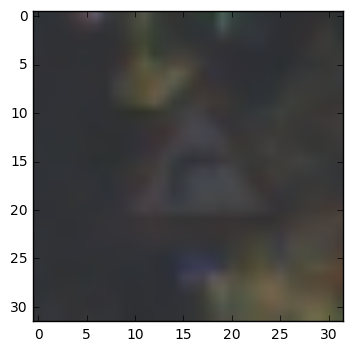

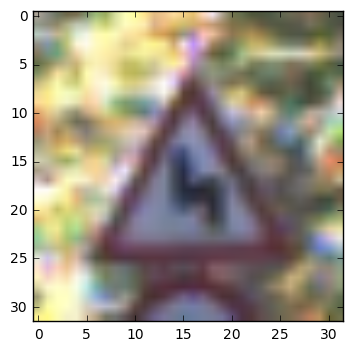

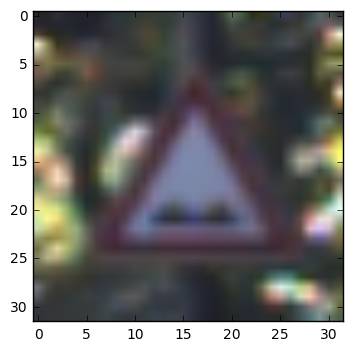

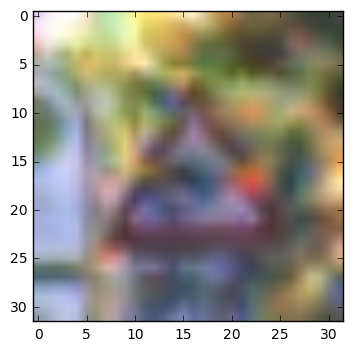

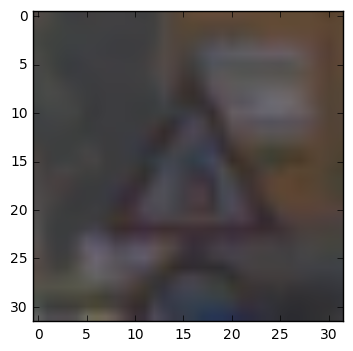

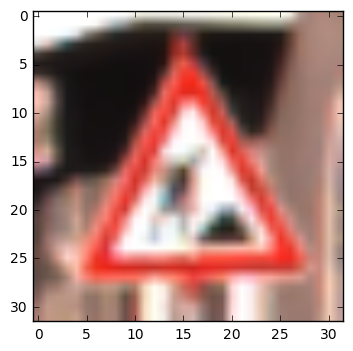

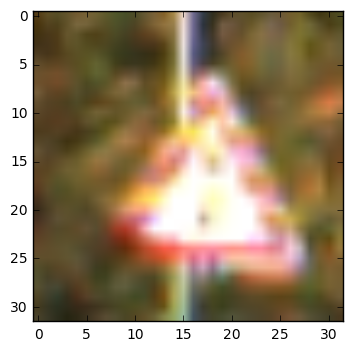

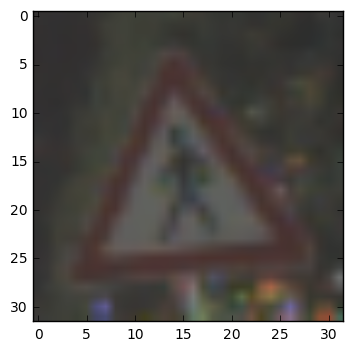

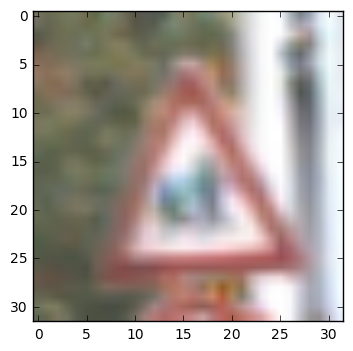

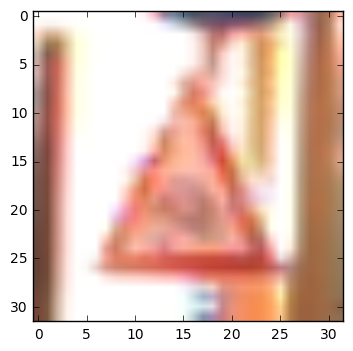

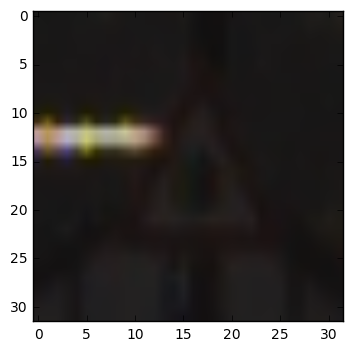

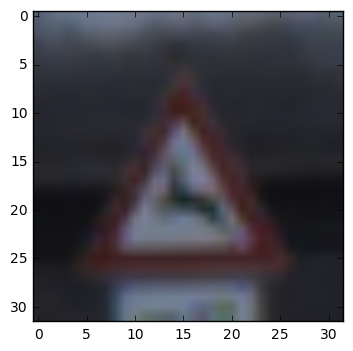

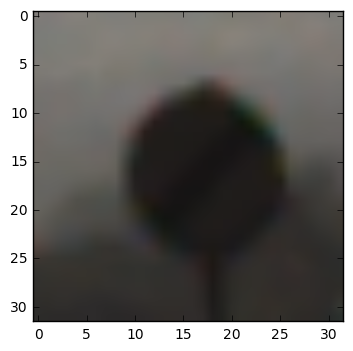

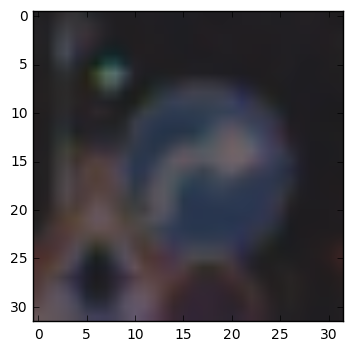

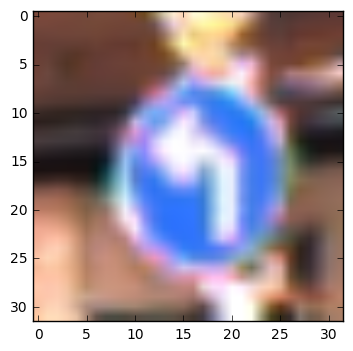

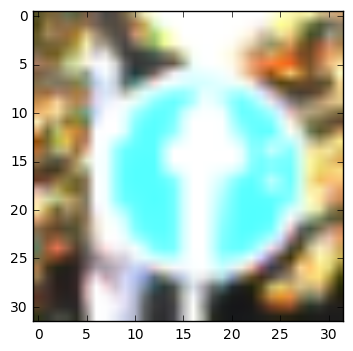

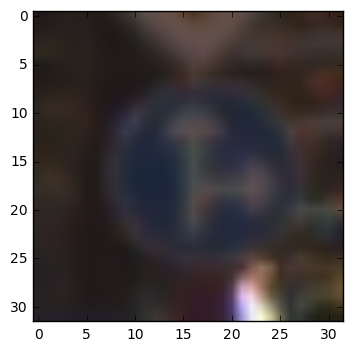

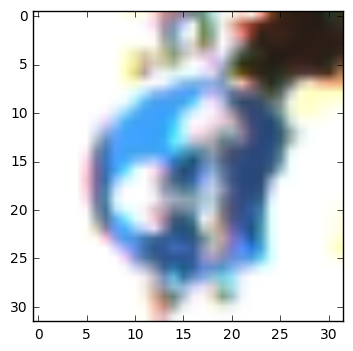

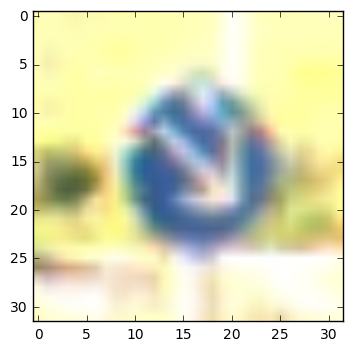

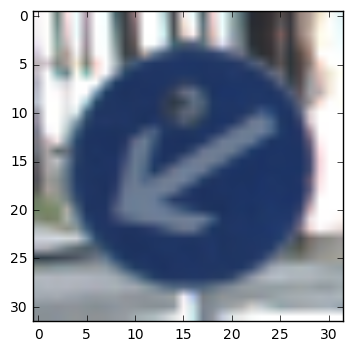

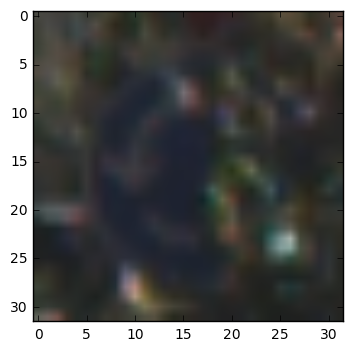

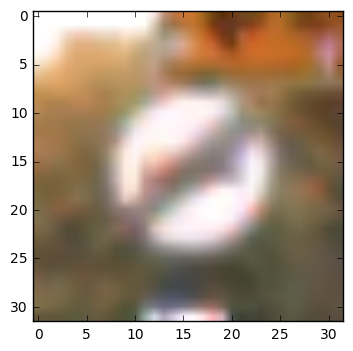

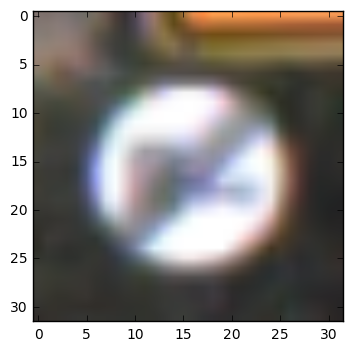

In [4]:
# Display one of each kind of image
def display_unique_classes(X, y,cmap=None):
    labels = set(y)
    for label in labels:
        idx = np.nonzero((y) == label)[0][0]
        image = X[idx,:,:]
        if cmap:
            plt.imshow(image,cmap)
        else:
            plt.imshow(image)
        plt.show()
        
display_unique_classes(X_train, y_train)

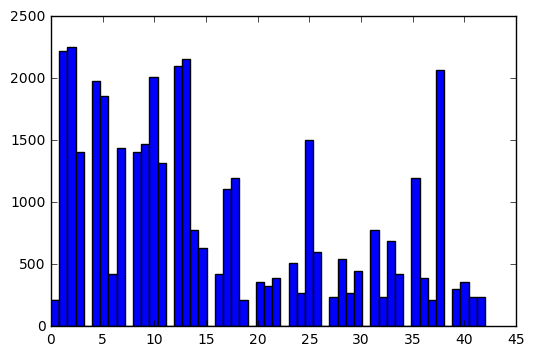

In [5]:
# As it can be seen, there are not an equal number of examples in all classes
plt.hist(y_train,bins=53);

In [6]:
# Compute the max and min observations for any class
# We can see that some classes have as many as 2 thousand examples,
# while another class has as few as 200 examples

dist = np.histogram(y_train, bins=range(44))
classes = dist[1]
counts = dist[0]
max_count = max(counts)
min_count = min(counts)

print("Max observations for a class:", max_count)
print("Min observations for a class:", min_count)

Max observations for a class: 2250
Min observations for a class: 210


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [7]:
def preprocess_data(data, labels):
    # Convert image to grayscale
    data = np.mean(data, axis=3)

    # One hot encode labels
    labels = (np.arange(n_classes) == labels[:,None]).astype(np.float)
    
    # Mean Subtraction to center the data at the origin
    data -= np.mean(data)
    
    # Normalization
    data /= np.std(data, axis = 0)
    
    # PCA and whitening?
    return data, labels


X_train, y_train_one_hot = preprocess_data(X_train, y_train)
X_test, y_test_one_hot = preprocess_data(X_test, y_test)

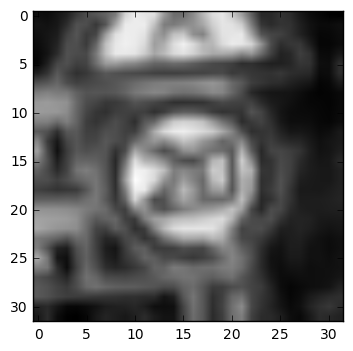

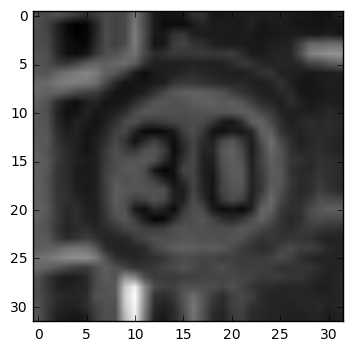

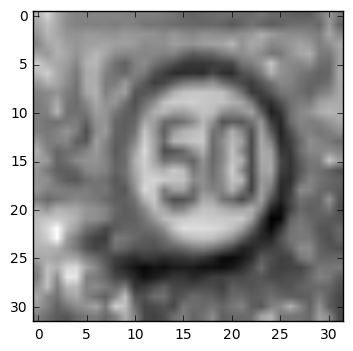

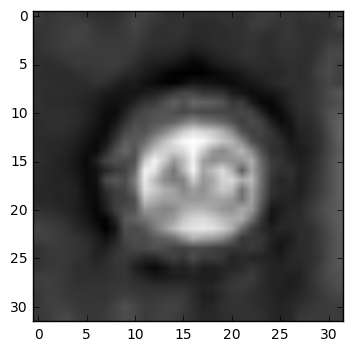

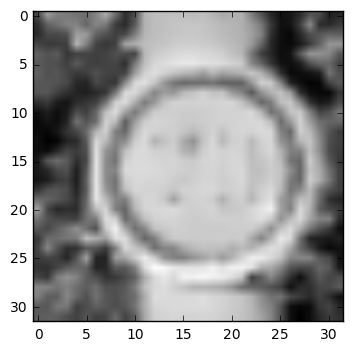

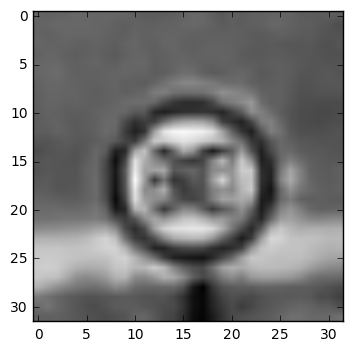

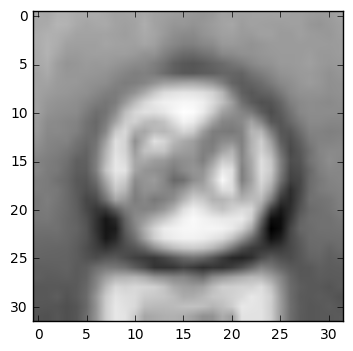

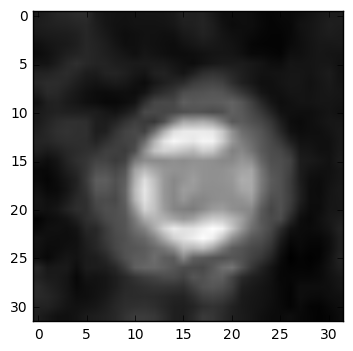

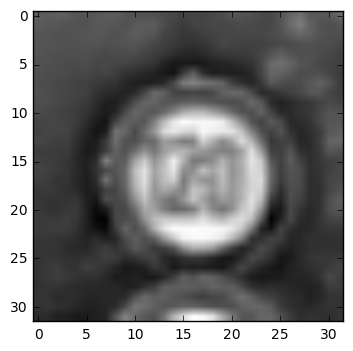

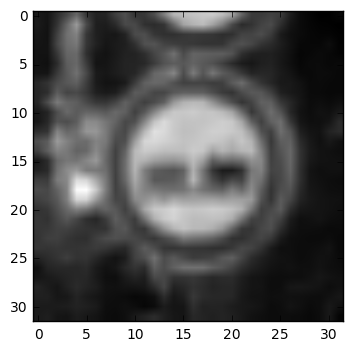

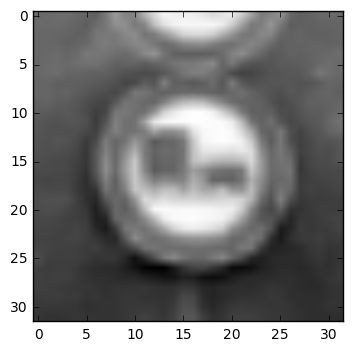

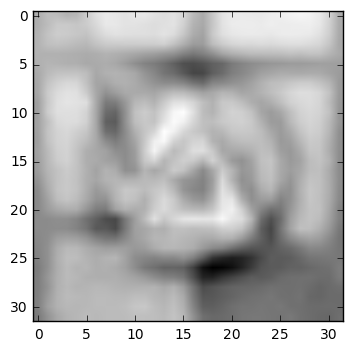

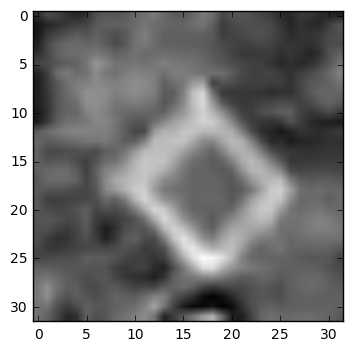

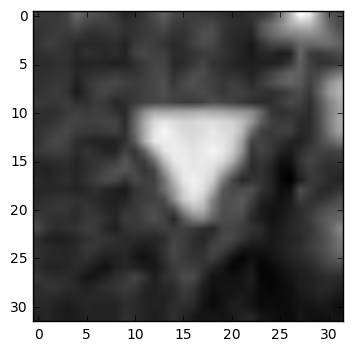

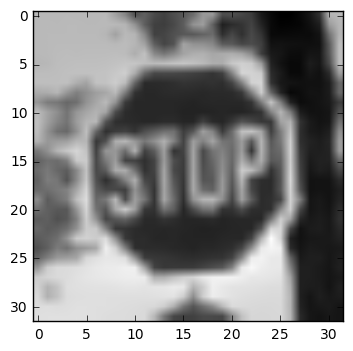

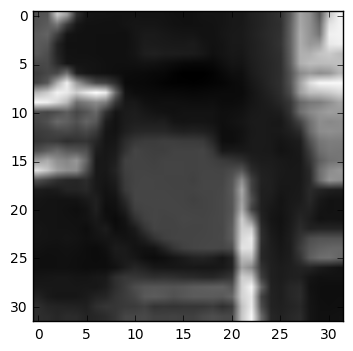

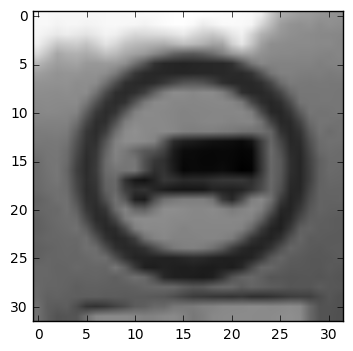

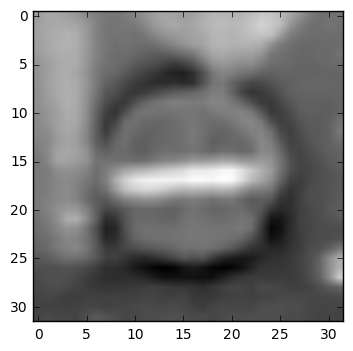

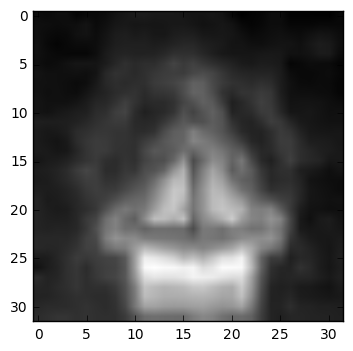

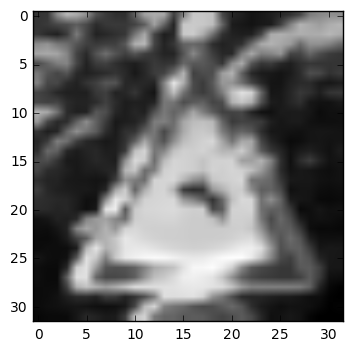

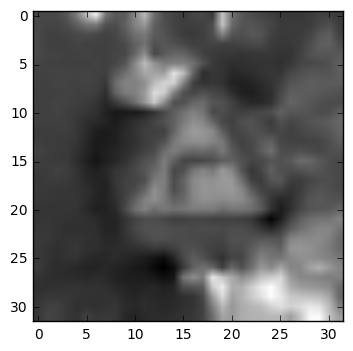

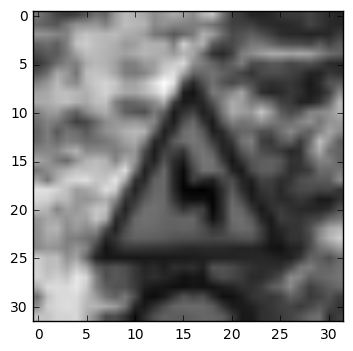

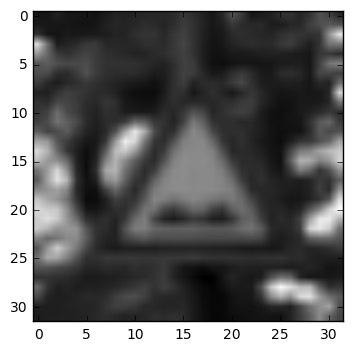

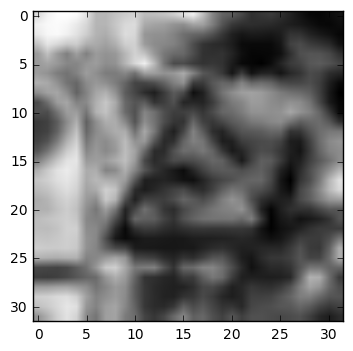

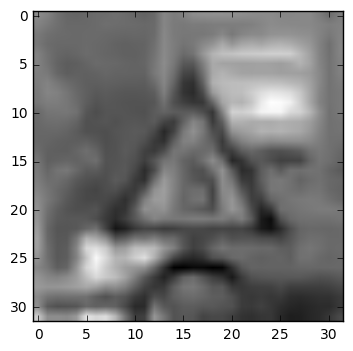

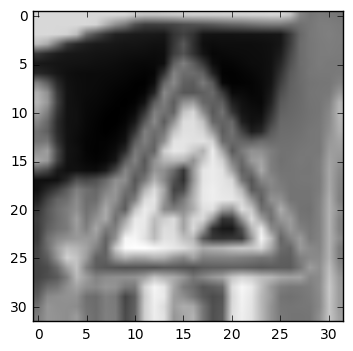

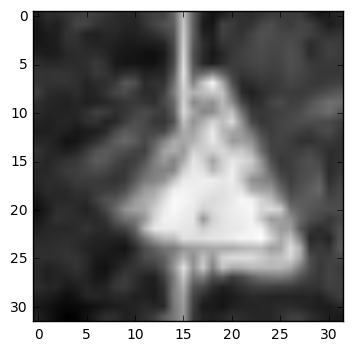

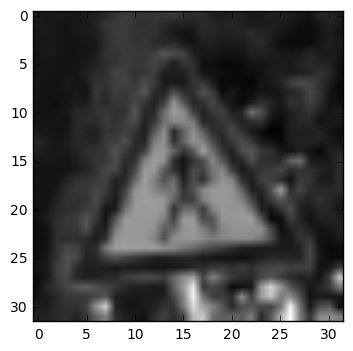

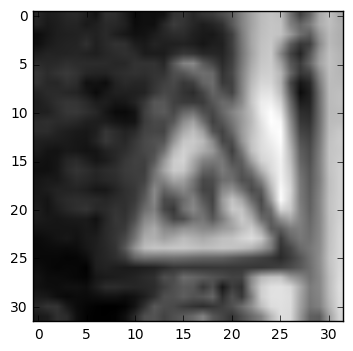

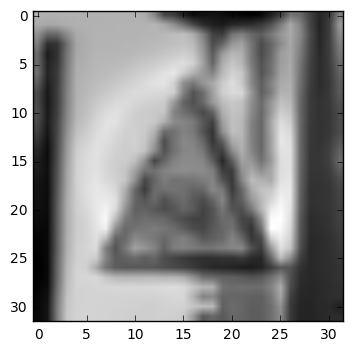

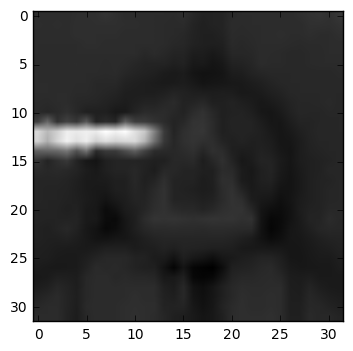

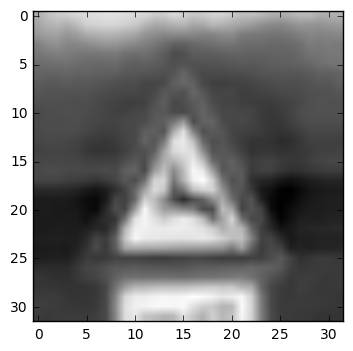

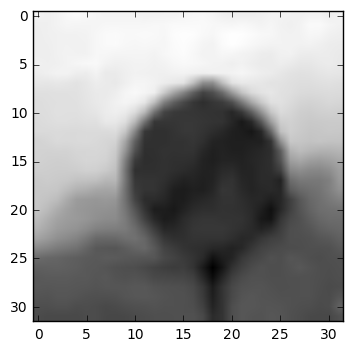

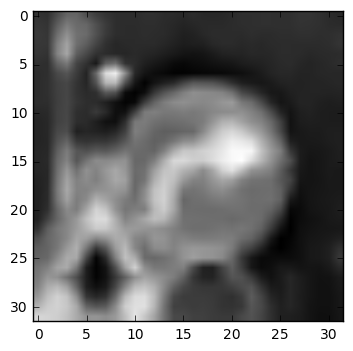

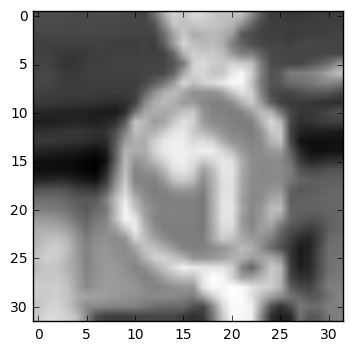

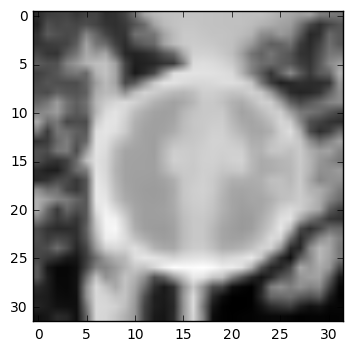

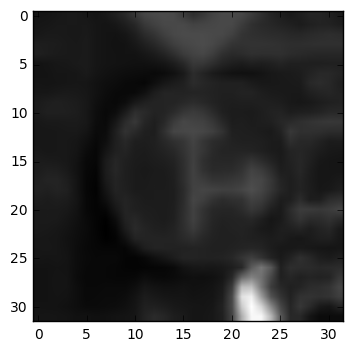

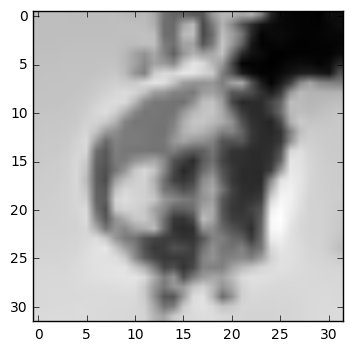

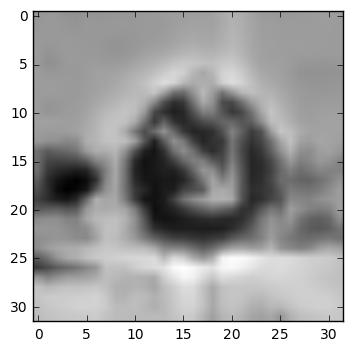

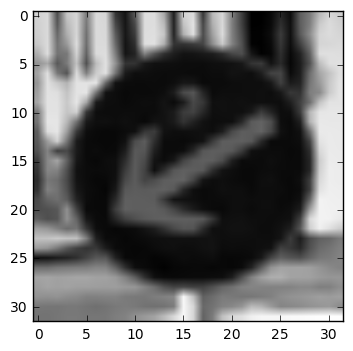

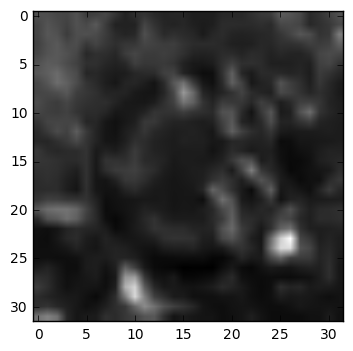

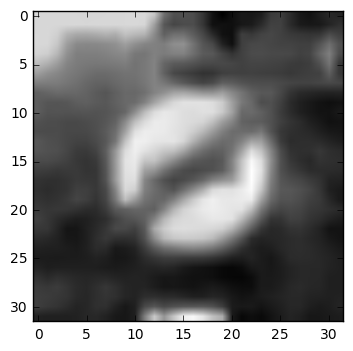

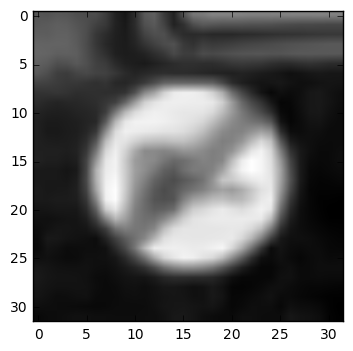

In [8]:
# Visualizing the pre-processed data
display_unique_classes(X_train, y_train, cmap="gray")

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**
- **Converting the image to grayscale**: This is done for simplicity and the fact that color alone should not cause the classifier to be biased
- **One hot encoding the labels**: This is done to make computing the cross entropy for the loss function possible
- **Mean Subtraction**: This centers the cloud of data around the origin in every dimension.
- **Normalization**: Normalize the data dimensions so that they are of the same scale. The way I have done this is by dividing each dimension by its standard deviation once it has been zero-centered. This is not strictly needed for images because the relative scales of pixels are already approximately equal

Possible further preprocessing could include:
1. PCA
2. Whitening

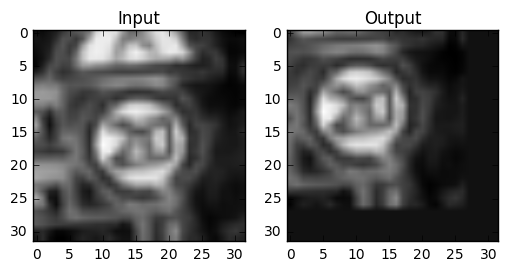

In [127]:
### Generate additional data for classes that have a small number of examples

def translate_image(image, tx, ty):
    """
        This function will result in a translated image
        Translation = shifting of the object's location
        
        image: the image to be translated
        tx: shift in the x direction
        ty: shift in the y direction
    """
    # Define the transformation matrix
    M = np.float32([[1, 0, tx],[0, 1, ty]])
    rows,cols = image.shape
    
    return cv2.warpAffine(image, M, (cols,rows))
    

plt.subplot(121),plt.imshow(X_train[0], cmap='gray'),plt.title('Input');
translated_image = translate_image(X_train[0], -5, -5)
plt.subplot(122),plt.imshow(translated_image, cmap='gray'),plt.title('Output');

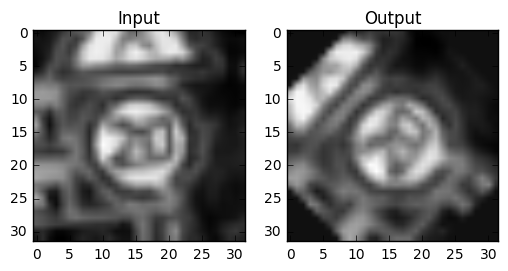

In [113]:
def rotate_image(image, angle):
    """
        This function rotates the given image through the given angle
        
        image: image to be rotated
        angle: angle through which the image is to be rotated
    """
    rows,cols = image.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2), angle, 1)
    
    return cv2.warpAffine(image, M, (cols,rows))

plt.subplot(121),plt.imshow(X_train[0], cmap='gray'),plt.title('Input');
rotated_image = rotate_image(X_train[0], 45);
plt.subplot(122),plt.imshow(rotated_image, cmap='gray'),plt.title('Output');

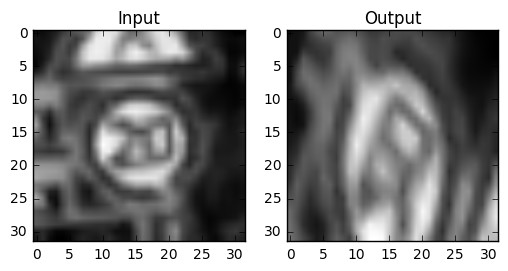

In [126]:
## Not sure if we want to use this as we get random images

def get_random_point(x_range, y_range):
    prop = 0.6
    x = random.randint(x_range - int(x_range * prop), x_range - int(x_range * (1-prop)))
    y = random.randint(y_range - int(y_range * prop), y_range - int(y_range * (1-prop)))
    return [x, y]

def get_n_random_points(n, x_range, y_range):
    return np.float32([get_random_point(x_range, y_range) for _ in range(n)])
    
def get_affine_transform(image):
    """
        In an affine transformation, 
        all parallel lines in the original image will
        stay parallel in the output image.
        
        We select three random points in the input image.
        And determine their position(randomly) in the output image
    """
    rows,cols = image.shape
    pts1 = get_n_random_points(3, rows, cols)
    pts2 = get_n_random_points(3, rows, cols)
    M = cv2.getAffineTransform(pts1, pts2)
    return cv2.warpAffine(image, M, (cols,rows))
    

plt.subplot(121),plt.imshow(X_train[0], cmap='gray'),plt.title('Input');
affine_transformed_image = get_affine_transform(X_train[0]);
plt.subplot(122),plt.imshow(affine_transformed_image, cmap='gray'),plt.title('Output');

In [96]:
### split the data into training/validation/testing sets here.

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

##### Training, Validation and Testing data sets


##### Generating additional data
- As can be seen from the histogram and the min and the max computed below that, some classes have as many as 2000 examples while another class has as few as 200 examples.
- This will cause the classifier to be biased towards the classes that have a larger number of examples
- To prevent this, we generate additional test data for classes which have a smaller number of examples
- There are three ways in which I am generating additional data:
1. Translations: Shifting the image in the x and y directions
2. Rotation of the image through various angles
3. Affine transformations of the image

In [7]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [8]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [9]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [10]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [11]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.